In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
import numpy as np
import elfi # install cython -> conda install cython to avoid fallback to numpy
import scipy.stats as ss
import pylab as plt
from pyabc.plots import plot_marginals
%matplotlib notebook

### The simulation model

In [2]:
def simulator(mu, sigma, batch_size=1, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(batch_size, 30), random_state=random_state)

def mean(y):
    return np.mean(y, axis=1)

def var(y):
    return np.var(y, axis=1)

### Observed data

In [3]:
# Set the generating parameters that we will try to infer
mean0 = 1
std0 = 3

# Generate some data (using a fixed seed here)
np.random.seed(20170525)
y0 = simulator(mean0, std0)
print(y0)

[[ 3.7990926   1.49411834  0.90999905  2.46088006 -0.10696721  0.80490023
   0.7413415  -5.07258261  0.89397268  3.55462229  0.45888389 -3.31930036
  -0.55378741  3.00865492  1.59394854 -3.37065996  5.03883749 -2.73279084
   6.10128027  5.09388631  1.90079255 -1.7161259   3.86821266  0.4963219
   1.64594033 -2.51620566 -0.83601666  2.68225112  2.75598375 -6.02538356]]


### Own class

In [4]:
# setup
mu = pyabc.Prior('unif', -2,4, name="mu")
sigma = pyabc.Prior('unif', 1,4, name="sigma")

rej_samp = pyabc.RejectionSampler(
    priors=[mu, sigma], 
    simulator=simulator, 
    summaries=[mean, var],
    observation=y0
)


smc_samp = pyabc.SMCSampler(
    priors=[mu, sigma], 
    simulator=simulator, 
    summaries=[mean, var],
    observation=y0
)

mcmc_samp = pyabc.MCMCSampler(
    priors=[mu, sigma], 
    simulator=simulator, 
    summaries=[mean, var],
    observation=y0
)


abcde_samp = pyabc.ABCDESampler(
    priors=[mu, sigma], 
    simulator=simulator, 
    summaries=[mean, var],
    observation=y0
)


bolfi = pyabc.BOLFI(priors=[mu, sigma],
                  simulator=simulator,
                  summaries=[mean, var],
                  observation=y0,
                  domain=[(-2,2), (1,5)])

In [5]:
rej_samp.sample(nr_samples=100, threshold=.1)

Rejection sampler started with threshold: 0.1 and number of samples: 100
Samples:    100 - Threshold: 0.1000 - Iterations:     284000 - Acceptance rate: 0.000352 - Time:    32.80 s


In [6]:
smc_samp.sample(nr_samples=1000, thresholds= [2,1,.5,.1])

SMC sampler started with thresholds: [2, 1, 0.5, 0.1] and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 0.10 - Iterations:    1033888 - Acceptance rate: 0.000967 - Time:   804.59 s


In [7]:
mcmc_samp.sample(nr_samples=100, threshold= .1, step_size = [1,1])

MCMC sampler started with threshold: 0.1 and number of samples: 100
Samples:    100 - Threshold: 0.1000 - Iterations:     128440 - Acceptance rate: 0.000779 - Time:    65.19 s


In [8]:
abcde_samp.sample(nr_samples=100, nr_groups = 10, nr_iter = 200, burn_in = 100, alpha = 0.1, beta = 0.1, kappa = 0.9)

ABC-Differential-Evolution sampler started with number of samples: 100
initializing pools
starting iteration [ 100 ]
Samples:    100 - Iterations:        200 - Acceptance rate: None - Time:    40.95 s


In [9]:
bolfi.sample(nr_samples=1000, threshold=0.01, n_chains=10)

BOLFI sampler started with threshold: 0.01 and number of samples: 10000
Starting Bayesian Optimization
Starting MCMC sampling with approximative likelihood
Samples:  10000 - Threshold: keiner - Iterations:      10010 - Acceptance rate: 0.629071 - Time:    47.21 s


<IPython.core.display.Javascript object>


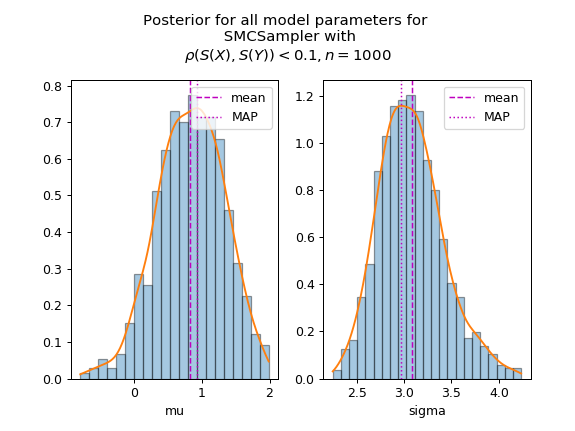

<IPython.core.display.Javascript object>


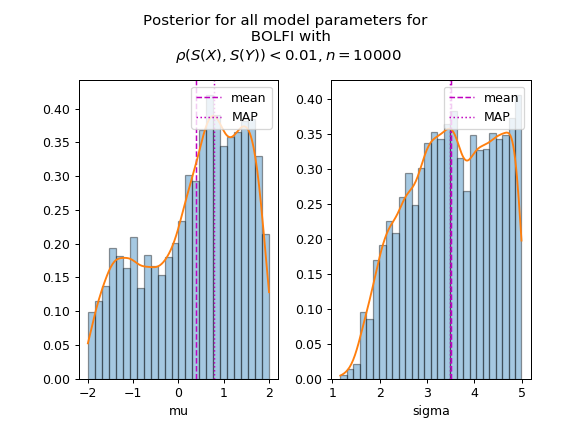

In [13]:
#plot_marginals(rej_samp, kde=True, normed=True)
#plot_marginals(mcmc_samp, kde=True, normed=True)
f = plot_marginals(smc_samp, kde=True, normed=True)
f.savefig('smc.png')
#plot_marginals(abcde_samp, kde=True, normed=True)
f = plot_marginals(bolfi, kde=True, normed=True)
f.savefig('bolfi.png')

## ELFI

In [ ]:
# Prior
elfi.new_model() # important to reset, otherwise rerun the code will produce two nodes for S1, S2 and so on
mu = elfi.Prior('uniform', -2, 4)
sigma = elfi.Prior('uniform', 1, 4)

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator, mu, sigma, observed=y0)

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim, name="mean")
S2 = elfi.Summary(var, sim, name="var")

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1, S2)

In [ ]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

In [ ]:
rej = elfi.Rejection(d, batch_size=10000, seed=30052017)
%time res = rej.sample(1000, threshold=.5)
print(res)

In [ ]:
res.plot_marginals()